In [129]:
%pip install pysd
import os
import pysd
import numpy as np
import pandas as pd

from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
from datetime import datetime

In [130]:
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor



In [135]:
model = pysd.load('./bass.py')

In [137]:
def run_model(model, params=None, return_columns=None):
    model.reload()
    kwargs = {}
    if params is not None:
        kwargs['params'] = params
    values = model.run(**kwargs)
    return values

In [138]:
def plot_chart(values):
    labels = ['Potential Customers', 'Our customers', 'Competitor Customers']
    values = values[labels]
    values_len = len(values)
    colors = ['g', 'b', 'r']

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Market Segmentation")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Data")
    for label, color in zip(labels, colors):
        ax1.plot(np.arange(values_len), values[label], '-', label=label, c=color)
    ax1.legend()
    plt.show()

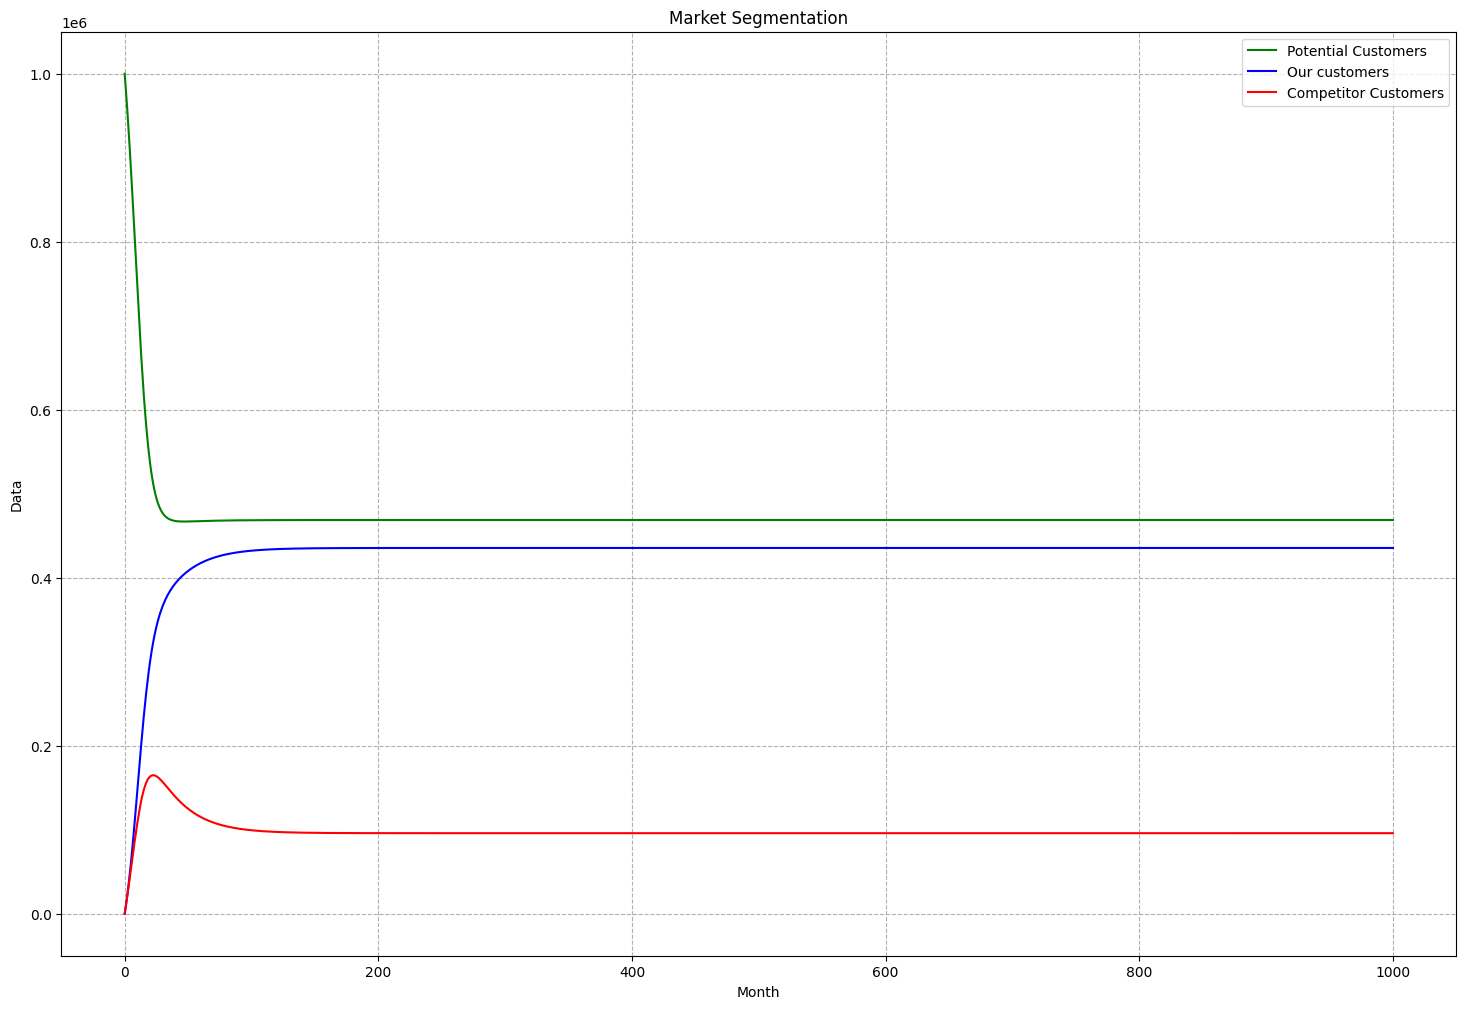

In [139]:
config = {
    "FINAL TIME": 1000,
    "p11": 0.2,
    "p13": 0.4,
    "p21": 0.1,
    "p23": 0.2,
    "efficiency_word_of_mouth": 0.015,
    "efficiency_marketing": 0.01,
    "sociability": 100
}


values = run_model(model, params=config)
plot_chart(values)

<Axes: xlabel='time'>

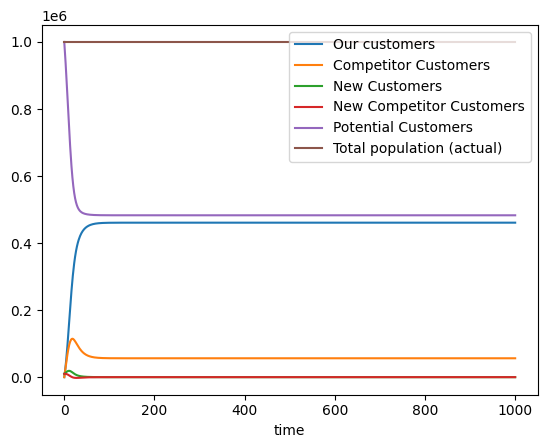

In [7]:
result = model.run(params= {
    "FINAL TIME": 1000,
    "p11": 0.2,
    "p13": 0.4,
    "p21": 0.1,
    "p23": 0.3}, return_columns=['Our customers', 'Competitor Customers',
                          'New Customers', 'New Competitor Customers',
                          'Potential Customers', 'Total population (actual)'])
result.plot()

In [8]:
result = model.run()
result.iloc[-1]

FINAL TIME                                     1.000000e+03
INITIAL TIME                                   0.000000e+00
SAVEPER                                        1.000000e+00
TIME STEP                                      1.000000e+00
Our customers                                  4.608149e+05
Potential Customers                            4.828595e+05
Competitor Customers                           5.632556e+04
New Customers                                  7.503331e-12
New Potential Customers                       -1.273293e-11
New Competitor Customers                      -9.094947e-13
Potential Customers to Our Customers           7.158126e+04
Potential Customers to Competitor Customers    8.908195e+03
Our Customers to Potential Customers           7.373039e+04
Competitor Customers to Potential Customers    6.759067e+03
Our Customers to Competitor Customers          1.495046e+03
Competitor Customers to Our Customers          3.644174e+03
Demand from Marketing                   

Для данной задачи я предлагаю следующее определение сходимости: наблюдения $X=\{x_0..x_T \}$ считаются сходящимися в момент времени $T$, если $|x_T-x_i| < \epsilon$ для $i \in [1..5]$ и $\epsilon =0.05$.


Пусть количество клиентов нашей компании - функция $O(t)$, определенная для $t \in [0, \infty]$. Аналогично, количество потенциальных клиентов - $P(t)$, а количество клиентов конкурентов - $C(t)$. Таким образом, задано, что модель Басса находится в равновесии в момент времени $T$, если все $O(T)$, $P(t)$ и $C(t)$ сходятся. Пусть также количество клиентов в нашей и конкурентской компаниях в момент времени $T$ равно $O(T)=M_1$ и $C(t)=M_2$.



In [96]:
def get_equilibrium(values, eps=5e-1):
    """
    Method that computes market segmentation for a given model run
    """
    labels = ['Potential Customers', 'Our customers', 'Competitor Customers']
    new_labels = []
    new_values = values.copy()
    for label in labels:
        for offset in range(1, 6):
            new_label = f"{label} - {offset}"
            new_labels.append(new_label)
            new_values[new_label] = values[label].diff(periods=offset).abs()
    diffs = new_values[new_labels]
    converged = values[(diffs < eps).all(axis='columns')]
    if converged.empty:
        return None, None
    M1, M2 = converged[labels[1:]].iloc[0]
    return M1, M2


In [10]:
def simulate(p11, p13, p21, p23, final_time=100):
    """
    Method that runs simulation with given values
    of P11, P13, P21, and P23.
    """
    config = {
        "final_time": final_time,
        "p11": p11,
        "p13": p13,
        "p21": p21,
        "p23": p23,
        "efficiency_word_of_mouth": 0.015,
        "efficiency_marketing": 0.01,
        "sociability": 100
    }
    values = run_model(model, params=config)
    equilibrium = get_equilibrium(values)
    return np.array(equilibrium)

In [11]:
def simulate_wrapper(args):
    return simulate(*args)

In [12]:
def generate_grid(step=0.1, preferences=None):
    """
    Method that generates a grid of P11, P13, P21, P23. Can forced to compute
    the grid within a certain interval for each P.
    """
    if preferences is None:
        preferences = [[0, 1]] * 4
    preferences = np.array(preferences)
    assert preferences.shape == (4, 2), "Preferences is list of list of elements with two items: lower and upper bound for P"
    space = [np.arange(pref[0], pref[1] + step, step) for pref in preferences]
    grid = np.array(np.meshgrid(*space, indexing='ij')).T.reshape(-1, 4)
    labels =  ["P11", "P13", "P21", "P23", "S1", "S2"]
    df = pd.DataFrame(data=grid, columns=labels[:4])
    temp = pd.DataFrame(data=np.zeros((len(df), 2)), columns=labels[4:])
    for idx, label in enumerate(labels[4:]):
        temp[label] = df[labels[idx * 2]] + df[labels[idx * 2 + 1]]
    df = df[(temp <= 1.).all(axis='columns')].reset_index(drop=True)
    return df

In [13]:
def get_mapping(df):
    """
    Method that computes equilibrium of a system with a given
    set of P11, P13, P21, P23. Uses multiple processes to increase
    the speed
    """
    work = [[r["P11"], r["P13"], r["P21"], r["P23"]] for _, r in df.iterrows()]
    with Pool(max(os.cpu_count() - 1, 1)) as p:
        ground_truth = list(tqdm(p.imap(simulate_wrapper, work), total=len(work)))
    targets = pd.DataFrame(data=ground_truth, columns=["M1", "M2"])
    return targets

In [97]:
def export(df, flag):
    if not flag:
        return
    if not os.path.exists('./data'):
        os.makedirs('./data')
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filepath = os.path.join('./data', f'train | {timestamp}.csv')
    df.to_csv(filepath)
    return True

In [98]:
def compose_dataset(step=0.1, preferences=None, save=True):
    df = generate_grid(step=step, preferences=preferences)
    targets = get_mapping(df)
    dataset = pd.concat([df, targets], axis=1).fillna(value=np.nan)
    export(dataset, save)
    return dataset

In [ ]:
preferences = [[0.1, 0.9]] * 4
df = compose_dataset(step=0.05, preferences=preferences)

100%|██████████| 18496/18496 [30:27<00:00, 10.12it/s]


In [16]:
df2 = pd.read_csv("./data/train2.csv", index_col=[0])
#df2 = pd.read_csv("./train2.csv", index_col=[0])

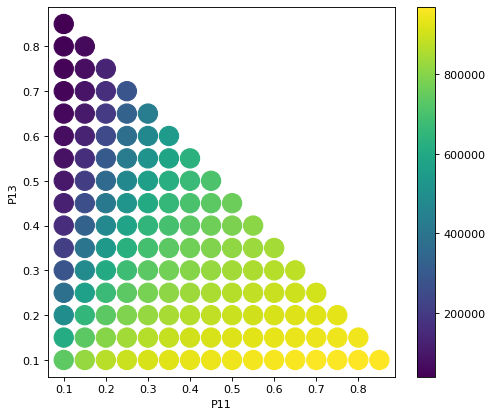

In [17]:
from matplotlib.pyplot import figure

def visualize(dataset, competitor_strategy, tol=1e-5):
    p21, p23 = competitor_strategy
    data = dataset[(abs(dataset["P21"] - p21) < tol) & (abs(dataset["P23"] - p23) < tol)]
    figure(figsize=(7, 6), dpi=80)
    plt.scatter(data["P11"], data["P13"], c=data["M1"], s=300)
    plt.xlabel("P11")
    plt.ylabel("P13")
    plt.colorbar()

visualize(df2, [0.1, 0.5])

Добавим нашу метрику М и перейдем к ML модели

In [18]:
df2 = df2.assign(M = df2['M1'] / df2['M2'])
df2

,P11,P13,P21,P23,M1,M2,M
0,0.10,0.10,0.1,0.10,386290.563631,386290.563631,1.000000
1,0.15,0.10,0.1,0.10,805123.176640,32270.764621,24.948996
2,0.20,0.10,0.1,0.10,862215.046671,13026.037623,66.191659
3,0.25,0.10,0.1,0.10,891642.933342,7205.685983,123.741575
4,0.30,0.10,0.1,0.10,910348.249038,4608.320631,197.544468
...,...,...,...,...,...,...,...
18491,0.15,0.75,0.1,0.85,85279.439958,41348.947961,2.062433
18492,0.20,0.75,0.1,0.85,150685.052733,35927.056367,4.194194
18493,0.10,0.80,0.1,0.85,49222.877173,44437.111733,1.107697
18494,0.15,0.80,0.1,0.85,73727.818113,42209.323190,1.746719


In [19]:
display(df2.dtypes)


P11    float64
P13    float64
P21    float64
P23    float64
M1     float64
M2     float64
M      float64
dtype: object

In [20]:
df2.dropna(inplace=True)

In [21]:
y = df2['M']
X = df2.drop(columns=['M1', 'M2', 'M']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [22]:
list(X_train.columns)


['P11', 'P13', 'P21', 'P23']

Решил попробовать регрессии, получилось не очень) Взял модель случайного леса (свою любимую) (потому что я решающий пень), который показал хорошие результаты

In [23]:
numeric_features = list(X_train.columns)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.8f" % mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Train RMSE = 198.25468823
Test RMSE = 195.15671571
Test R^2 = 0.51892069


In [24]:
rfr = RandomForestRegressor(n_estimators=500, max_features=int(X_train.shape[1] / 3))
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 15.83087534
Test R^2 = 0.99683437


Подберем гридом  параметры

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
param_grid = {
    'max_depth': [80, 90, 100],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 700]
#     'max_depth': [80, 100],
#     'max_features': [1, 2],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 300, 500, 600]
}

rfr_grid = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfr_grid, param_grid = param_grid, scoring="neg_root_mean_squared_error",
                          cv = 3, n_jobs = -1)

In [ ]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 700}


In [ ]:
#{'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 700}

In [ ]:
print(-grid_search.best_score_)


In [26]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, test_features, test_labels)

# используем подобранные GridSearch'ем параметры
rfr_best = RandomForestRegressor(n_estimators=700, max_features=3, max_depth=90, min_samples_leaf=3, min_samples_split=8)
rfr_best.fit(X_train, y_train)
rfr_best.feature_name = df2.columns
y_pred = rfr_best.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 11.79055512


Приступим к построению линии уровня. Например, меня интересует случай, когда параметры конкурента $P{21}=0.53$, $P{23}=0.35$, а параметры нашей компании $P{11}=0.58$, $P{13}=0.39$. Найдем рыночное сегментирование, запустив нашу имитационную модель

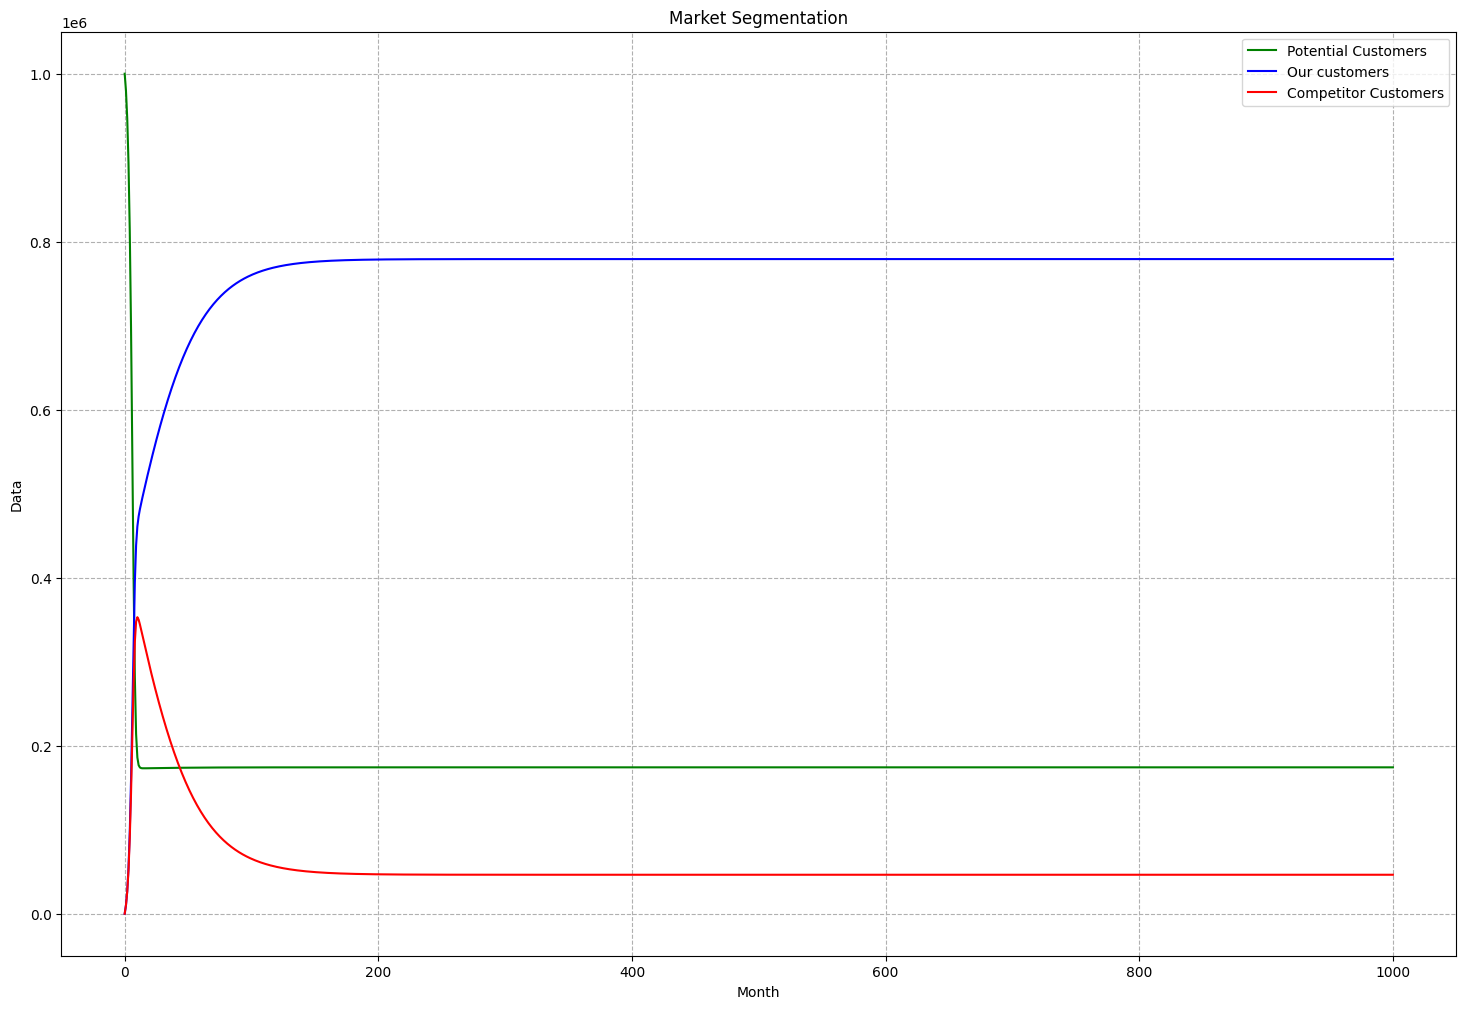

In [42]:
config = {
    "FINAL TIME": 1000,
    "p11": 0.58,
    "p13": 0.39,
    "p21": 0.53,
    "p23": 0.35,
    "efficiency_word_of_mouth": 0.015,
    "efficiency_marketing": 0.01,
    "sociability": 100
}


values = run_model(model, params=config)
plot_chart(values)

In [43]:
values

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Our customers,Potential Customers,Competitor Customers,New Customers,New Potential Customers,New Competitor Customers,...,Total population (actual),p11,p13,p21,p23,Word of Mouth impact,Marketing impact,Rate,k,tr
time,,,,,,,,,,,,,,,,,,,,,
0,1000,0,1,1,0.000000,1000000.000000,0.000000,1.000000e+04,-2.000000e+04,1.000000e+04,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
1,1000,0,1,1,10000.000000,980000.000000,10000.000000,1.677063e+04,-3.295700e+04,1.618637e+04,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
2,1000,0,1,1,26770.633200,947043.000000,26186.366800,2.738375e+04,-5.287130e+04,2.548755e+04,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
3,1000,0,1,1,54154.382816,894171.697433,51673.919751,4.275157e+04,-8.106255e+04,3.831097e+04,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
4,1000,0,1,1,96905.955388,813109.152249,89984.892363,6.196953e+04,-1.152669e+05,5.329738e+04,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1000,0,1,1,779337.975729,174269.445367,46392.578903,8.185452e-12,-1.182343e-11,-4.547474e-12,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
997,1000,0,1,1,779337.975729,174269.445367,46392.578903,9.094947e-12,-1.091394e-11,-4.547474e-12,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6
998,1000,0,1,1,779337.975729,174269.445367,46392.578903,1.000444e-11,-1.000444e-11,-3.637979e-12,...,1000000.0,0.58,0.39,0.53,0.35,0.015,0.01,100,0.4,0.6


In [44]:
M1 = 779337.975729
M2 = 46392.578903
M0 = M1 / M2
print(M1 / M2)

16.798763814326428


Посмотрим на значения P11, P13 в нашем датасете

In [49]:
p11, p13, p21, p23 = 0.58, 0.39, 0.55, 0.35
tol = 1e-6

In [75]:
def get_snapshot(df):
    """
    Method that gives a snapshot of parameter space with a given P21, P23
    """
    data = df2[(abs(df2["P21"] - p21) < tol) & (abs(df2["P23"] - p23) < tol)]
    data["M (pred.)"] = data.apply(lambda x: rfr_best.predict([[x['P11'], x['P13'], x['P21'], x['P23']]])[0], axis=1)

    return data

In [50]:
data123 = get_snapshot(df2)
data123

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

,P11,P13,P21,P23,M1,M2,M,M (pred.)
10744,0.10,0.10,0.55,0.35,4775.032515,830239.143569,0.005751,0.035987
10745,0.15,0.10,0.55,0.35,5481.945567,829616.508079,0.006608,0.036219
10746,0.20,0.10,0.55,0.35,6434.529950,828777.489447,0.007764,0.037195
10747,0.25,0.10,0.55,0.35,7787.784576,827585.566365,0.009410,0.041638
10748,0.30,0.10,0.55,0.35,9861.756321,825758.847342,0.011943,0.244528
...,...,...,...,...,...,...,...,...
10875,0.15,0.75,0.55,0.35,3663.056974,830090.527726,0.004413,0.004474
10876,0.20,0.75,0.55,0.35,4065.187980,829612.506827,0.004900,0.005041
10877,0.10,0.80,0.55,0.35,3257.660926,830495.261265,0.003923,0.004167
10878,0.15,0.80,0.55,0.35,3571.893113,830114.282162,0.004303,0.004434


In [99]:
def select_area(df, M):
    """
    returns area with alike market segmentation.

    """
    return df[(abs(df["M (pred.)"] - M) / 100 < 0.07)]

In [64]:
areas = select_area(data123, M = 16.7987)
areas

,P11,P13,P21,P23,M1,M2,M,M (pred.)
10798,0.55,0.25,0.55,0.35,829163.242623,50183.864295,16.522507,12.80833


Для нахождения линии уровня создадим еще один датасет с меньшим шагом, закрепим значения конкурента и заново обучим модель

In [67]:
preferences = [[0.1, 0.9], [0.1, 0.9], [0.55, 0.55], [0.35, 0.35]]
compose_dataset(step=0.01, preferences=preferences)

100%|██████████| 13284/13284 [23:22<00:00,  9.47it/s]


,P11,P13,P21,P23,M1,M2
0,0.10,0.10,0.55,0.35,4775.032515,830239.143569
1,0.11,0.10,0.55,0.35,4901.445582,830127.801144
2,0.12,0.10,0.55,0.35,5034.735218,830010.401762
3,0.13,0.10,0.55,0.35,5175.478487,829886.437116
4,0.14,0.10,0.55,0.35,5324.319009,829755.340255
...,...,...,...,...,...,...
13279,0.11,0.88,0.56,0.36,3203.666597,828704.852423
13280,0.12,0.88,0.56,0.36,3259.359932,828635.698691
13281,0.10,0.89,0.56,0.36,3136.371106,828773.789189
13282,0.11,0.89,0.56,0.36,3189.732737,828707.278146


In [68]:
mygrid2 = pd.read_csv("./data/grid2.csv", index_col=[0])
mygrid2.dropna(inplace=True)
mygrid2 = mygrid2.assign(M = mygrid2['M1'] / mygrid2['M2'])
mygrid2
y = mygrid2['M']
X = mygrid2.drop(columns=['M1', 'M2', 'M']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [70]:
rfr_best = RandomForestRegressor(n_estimators=700, max_features=3, max_depth=90, min_samples_leaf=3, min_samples_split=8)
rfr_best.fit(X_train, y_train)
rfr_best.feature_name = mygrid2.columns
y_pred = rfr_best.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 3.64752341


Добавим предсказанные значения М в датасет

In [79]:
def apply_model(df):
    """
    applies inferenced ML model to each entry.

    """
    new_data = df.copy()
    new_data["M (pred.)"] = new_data.apply(lambda x: rfr_best.predict([[x['P11'], x['P13'], x['P21'], x['P23']]])[0], axis=1)
    return new_data

second_approximation = apply_model(mygrid2)
second_approximation

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/l

,P11,P13,P21,P23,M1,M2,M,M (pred.)
0,0.10,0.10,0.55,0.35,4775.032515,830239.143569,0.005751,0.006118
1,0.11,0.10,0.55,0.35,4901.445582,830127.801144,0.005904,0.006138
2,0.12,0.10,0.55,0.35,5034.735218,830010.401762,0.006066,0.006242
3,0.13,0.10,0.55,0.35,5175.478487,829886.437116,0.006236,0.006324
4,0.14,0.10,0.55,0.35,5324.319009,829755.340255,0.006417,0.006476
...,...,...,...,...,...,...,...,...
13279,0.11,0.88,0.56,0.36,3203.666597,828704.852423,0.003866,0.003877
13280,0.12,0.88,0.56,0.36,3259.359932,828635.698691,0.003933,0.003970
13281,0.10,0.89,0.56,0.36,3136.371106,828773.789189,0.003784,0.003842
13282,0.11,0.89,0.56,0.36,3189.732737,828707.278146,0.003849,0.003868


Выберем значения предсказанных М, которые отличаются от метрики модели менее, чем на 7%

In [77]:
def select_area(df, M):
    """
    Method that returns area with alike market segmentation.

    """
    return df[(abs(df["M (pred.)"] - M) / 100 < 0.07)]

In [121]:
areas = select_area(second_approximation, M = 16.7987)

Заметил, что в датасет попали лишние значения, уберем

In [122]:
def get_snap(df):
    """
    Method that gives a snapshot of parameter space with a given P21, P23
    """
    data = df[(abs(df["P21"] - p21) < tol) & (abs(df["P23"] - p23) < tol)]

    return data

In [124]:
areas = get_snap(areas)
areas

,P11,P13,P21,P23,M1,M2,M,M (pred.)
40,0.50,0.10,0.55,0.35,898741.355425,43646.985144,20.591144,25.164952
202,0.51,0.12,0.55,0.35,896541.246297,37881.507467,23.666990,26.567271
281,0.51,0.13,0.55,0.35,881918.370591,46624.951561,18.915159,22.632430
359,0.51,0.14,0.55,0.35,864269.931192,58183.067622,14.854320,18.629017
360,0.52,0.14,0.55,0.35,892158.271181,34258.081596,26.042272,25.780986
...,...,...,...,...,...,...,...,...
2044,0.59,0.40,0.55,0.35,758823.722936,66042.188693,11.489984,11.272075
2045,0.60,0.40,0.55,0.35,778508.838531,48813.701560,15.948572,17.293043
2094,0.58,0.41,0.55,0.35,702238.568298,116932.975954,6.005479,7.021035
2095,0.59,0.41,0.55,0.35,747303.803632,73657.975280,10.145593,10.905218


In [125]:
def visualize_areas(areas):
    """
    Method that visualizes area of alike market segmentation.
    """
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_title(f"Region of freedom")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('P11')
    ax1.set_ylabel('P13')
    ax1.set_xlim((0, 1))
    ax1.set_ylim((0, 1))
    ax1.scatter(areas["P11"], areas["P13"], label='Freedom', c='g')
    ax1.legend()

    plt.show()

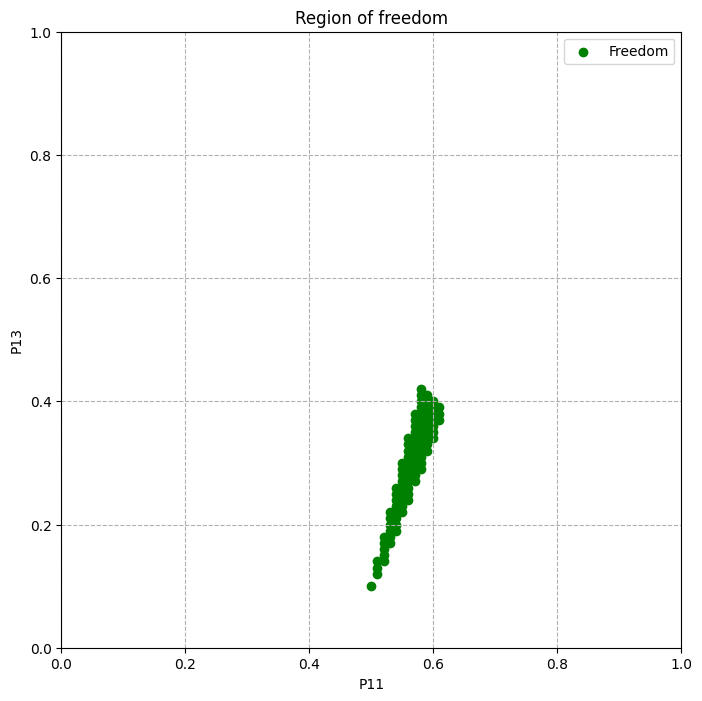

In [126]:
visualize_areas(areas)

Забыл про значения [0, 0.1]. Соберем датасет заново

In [84]:
preferences = [[0, 1], [0, 1], [0.55, 0.55], [0.35, 0.35]]
compose_dataset(step=0.01, preferences=preferences)

100%|██████████| 20604/20604 [34:55<00:00,  9.83it/s]


,P11,P13,P21,P23,M1,M2
0,0.00,0.00,0.55,0.35,4008.024656,831104.592964
1,0.01,0.00,0.55,0.35,4096.706092,831030.685988
2,0.02,0.00,0.55,0.35,4189.401759,830953.433344
3,0.03,0.00,0.55,0.35,4286.390285,830872.602856
4,0.04,0.00,0.55,0.35,4387.996303,830787.921552
...,...,...,...,...,...,...
20599,0.01,0.98,0.56,0.36,2637.716013,829284.589950
20600,0.02,0.98,0.56,0.36,2675.356195,829236.095051
20601,0.00,0.99,0.56,0.36,2591.927723,829331.493848
20602,0.01,0.99,0.56,0.36,2628.263404,829284.510310


In [85]:
mygrid3 = pd.read_csv("./data/grid3.csv", index_col=[0])
mygrid3.dropna(inplace=True)
mygrid3 = mygrid3.assign(M = mygrid3['M1'] / mygrid3['M2'])
mygrid3
y = mygrid3['M']
X = mygrid3.drop(columns=['M1', 'M2', 'M']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [87]:
rfr_best = RandomForestRegressor(n_estimators=700, max_features=3, max_depth=90, min_samples_leaf=3, min_samples_split=8)
rfr_best.fit(X_train, y_train)
rfr_best.feature_name = mygrid2.columns
y_pred = rfr_best.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 195130.43221805


In [91]:
second_approximation3 = apply_model(mygrid3)
second_approximation3

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/l

,P11,P13,P21,P23,M1,M2,M,M (pred.)
0,0.00,0.00,0.55,0.35,4008.024656,831104.592964,0.004823,0.005467
1,0.01,0.00,0.55,0.35,4096.706092,831030.685988,0.004930,0.005468
2,0.02,0.00,0.55,0.35,4189.401759,830953.433344,0.005042,0.005470
3,0.03,0.00,0.55,0.35,4286.390285,830872.602856,0.005159,0.005473
4,0.04,0.00,0.55,0.35,4387.996303,830787.921552,0.005282,0.005481
...,...,...,...,...,...,...,...,...
20599,0.01,0.98,0.56,0.36,2637.716013,829284.589950,0.003181,0.003196
20600,0.02,0.98,0.56,0.36,2675.356195,829236.095051,0.003226,0.003253
20601,0.00,0.99,0.56,0.36,2591.927723,829331.493848,0.003125,0.003180
20602,0.01,0.99,0.56,0.36,2628.263404,829284.510310,0.003169,0.003195


In [92]:
areas3 = select_area(second_approximation3, M = 16.7987)

In [127]:
areas3 = get_snap(areas3)

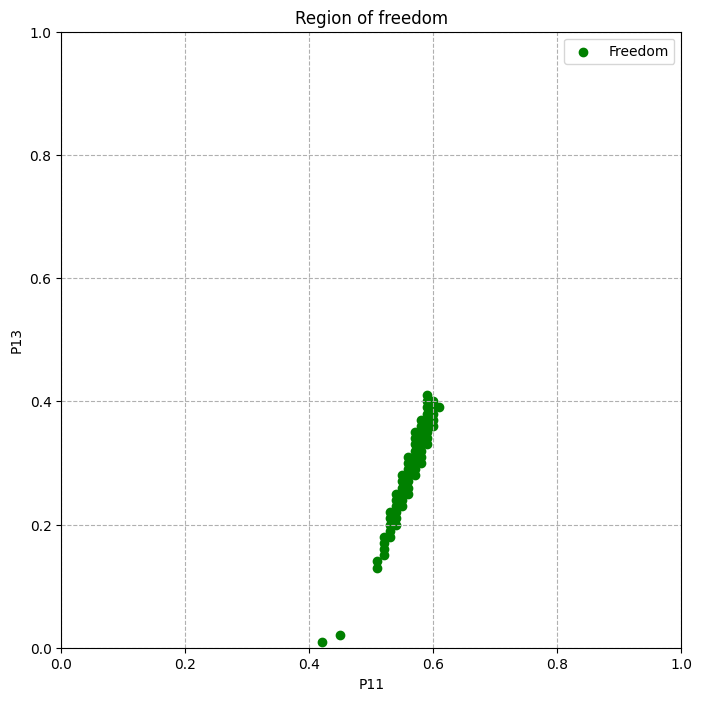

In [128]:
visualize_areas(areas3)

Кажется, что пропадают значения в линии уровня из-за ошибки модели в связи с выбранной метрикой М (оч большой разброс значений). Возможно, проблема бы решилась, если бы предсказывали М1/Total и М2/Total, но заслуженный студент фтиада увеличит допустимую разницу в рыночном сегментировании

In [113]:
def select_area_changed(df, M):
    """
    Method that returns area with alike market segmentation.

    """
    return df[(abs(df["M (pred.)"] - M) / 100 < 0.16)]

In [114]:
areas4 = select_area_changed(second_approximation3, M = 16.7987)

In [117]:
def get_snap(df):
    """
    Method that gives a snapshot of parameter space with a given P21, P23
    """
    data = df[(abs(df["P21"] - p21) < tol) & (abs(df["P23"] - p23) < tol)]

    return data

In [118]:
areas_snap = get_snap(areas3)

In [119]:
areas_snap

,P11,P13,P21,P23,M1,M2,M,M (pred.)
143,0.42,0.01,0.55,0.35,41554.573055,799615.026782,0.051968,14.964235
246,0.45,0.02,0.55,0.35,107591.094000,743749.782202,0.144660,13.058375
1286,0.51,0.13,0.55,0.35,881918.370591,46624.951561,18.915159,22.632430
1374,0.51,0.14,0.55,0.35,864269.931192,58183.067622,14.854320,18.629017
1462,0.52,0.15,0.55,0.35,880394.503944,40566.138898,21.702694,22.883148
...,...,...,...,...,...,...,...,...
3258,0.60,0.39,0.55,0.35,786465.522346,44909.655173,17.512170,18.242538
3259,0.61,0.39,0.55,0.35,798083.592270,35827.414790,22.275780,23.512247
3319,0.59,0.40,0.55,0.35,758823.722936,66042.188693,11.489984,11.272075
3320,0.60,0.40,0.55,0.35,778508.838531,48813.701560,15.948572,17.293043


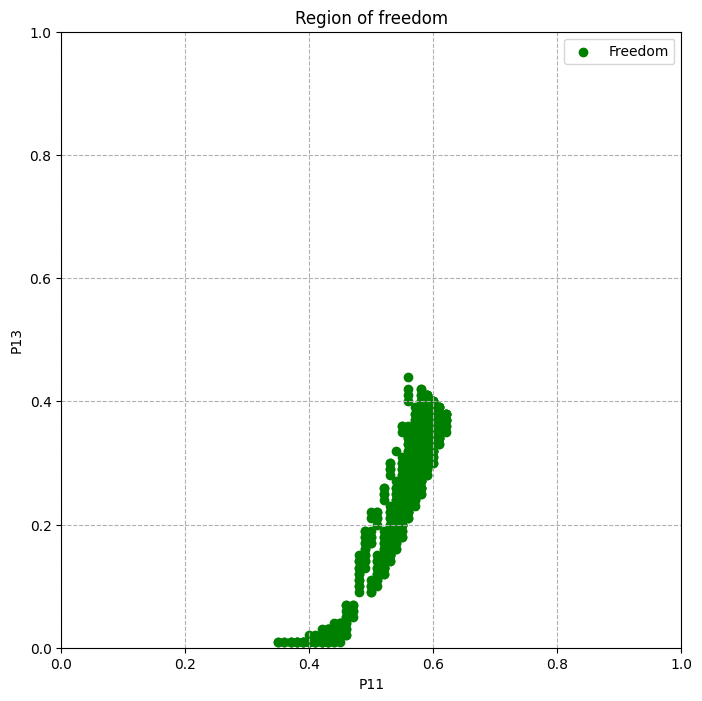

In [120]:
visualize_areas(areas4)

Итак, получили линию уровня, задающее искомое рыночное сегментирование